In [5]:
datos=spark.read.csv("Ecommerce_Customers.csv",
                     header=True,inferSchema=True)

In [7]:
datos.show(2,vertical=True),datos.printSchema()

-RECORD 0------------------------------------
 Email                | mstephenson@ferna... 
 Address              | 835 Frank TunnelW... 
 Avatar               | Violet               
 Avg Session Length   | 34.49726772511229    
 Time on App          | 12.65565114916675    
 Time on Website      | 39.57766801952616    
 Length of Membership | 4.0826206329529615   
 Yearly Amount Spent  | 587.9510539684005    
-RECORD 1------------------------------------
 Email                | hduke@hotmail.com    
 Address              | 4547 Archer Commo... 
 Avatar               | DarkGreen            
 Avg Session Length   | 31.92627202636016    
 Time on App          | 11.109460728682564   
 Time on Website      | 37.268958868297744   
 Length of Membership | 2.66403418213262     
 Yearly Amount Spent  | 392.2049334443264    
only showing top 2 rows

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: dou

(None, None)

In [8]:
datos.columns

['Email',
 'Address',
 'Avatar',
 'Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent']

In [9]:
datos.corr( 'Length of Membership', 'Yearly Amount Spent')

0.8090835682475807

In [10]:
datos.corr( 'Time on Website', 'Yearly Amount Spent')

-0.0026408446721578795

In [11]:
from pandas.plotting import scatter_matrix

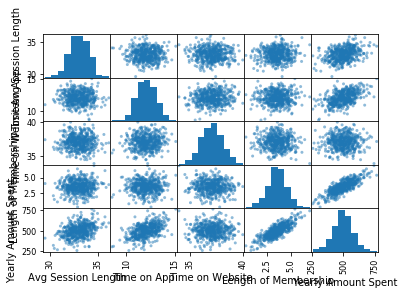

In [14]:
datosP=datos.toPandas()
g=scatter_matrix(datosP)

In [15]:
from pyspark.ml.feature import VectorAssembler

In [16]:
constructor=VectorAssembler(inputCols=['Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership'],outputCol="features")

In [19]:
datosF=constructor.transform(datos)

#aplica el constructor a datos para crear col. features

In [20]:
datosF.show()

+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+
|               Email|             Address|          Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|            features|
+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616|  4.0826206329529615|  587.9510539684005|[34.4972677251122...|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|    2.66403418213262|  392.2049334443264|[31.9262720263601...|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37

In [30]:
entrena,evalua=datosF.randomSplit([0.8,0.2])

In [31]:
entrena.count(),evalua.count()

(408, 92)

In [63]:
from pyspark.ml.regression import LinearRegression,DecisionTreeRegressor

In [64]:
lr=LinearRegression(labelCol='Yearly Amount Spent')
dt=DecisionTreeRegressor(labelCol='Yearly Amount Spent')

In [65]:
modelo=lr.fit(entrena)
modeloDt=dt.fit(entrena)

In [35]:
res=modelo.evaluate(evalua)

In [37]:
res.predictions.select('Yearly Amount Spent',"prediction").show()

+-------------------+------------------+
|Yearly Amount Spent|        prediction|
+-------------------+------------------+
|  576.4776071703129| 579.9351699667952|
|   418.602742095224|426.43842491922146|
| 494.55186108657256| 500.1817588245576|
| 256.67058229005585| 254.9479738297107|
|  497.8119300055205|  473.506001978192|
|  583.9778019715427| 585.1631114248366|
|  378.3309069068038|390.06799020356016|
| 483.67330801904563| 494.1024640697249|
|  443.4418600624623|448.26361449046885|
| 402.16712222372564| 422.5337606353355|
|  421.3266312569514| 422.8114625069486|
| 502.77107456549606|495.82084547854924|
|  513.1531118530668| 514.0796890475001|
|  433.0487690958266| 443.3550461474201|
|  497.3895577588434|481.21884468025905|
|  442.7228915742714| 435.5664896029093|
|  587.5747994806404| 597.5676192734468|
| 407.65717875932603| 395.4823469976377|
|  551.0230017027826| 549.4351878861785|
|  409.0704720533178| 395.6599762439125|
+-------------------+------------------+
only showing top

In [41]:
res.residuals.orderBy("residuals",ascending=False).show()

+------------------+
|         residuals|
+------------------+
|  30.5074552256242|
| 24.30592802732849|
|23.918318089151853|
|22.590988914125603|
|19.472208466331836|
| 18.91828156425754|
|16.170713078584356|
|15.316073073103894|
|14.632507196679796|
| 13.41049580940529|
|12.296067819282143|
|12.174831761688324|
|11.786131649477625|
|11.353359929814701|
|11.246454849553857|
|10.410924706015862|
| 8.737783108297663|
| 8.560217705960554|
| 7.910435720151099|
| 7.493695067694887|
+------------------+
only showing top 20 rows



In [42]:
res.residuals.summary().show()

+-------+--------------------+
|summary|           residuals|
+-------+--------------------+
|  count|                  92|
|   mean| 0.30452164741548166|
| stddev|  10.617217823160106|
|    min|  -22.55790902562012|
|    25%|     -7.131782860567|
|    50%|-0.13929155896846623|
|    75%|   5.969508179904892|
|    max|    30.5074552256242|
+-------+--------------------+



In [43]:
res.r2 #coeficiente de determinación para datos Evaluación

0.9826375176531905

In [45]:
modeloOK=lr.fit(datosF)#extiendo el modelo para todos los datos

In [48]:
modeloOK.summary.r2
#coeficiente de determinación para datos del modelo

0.9843155370226727

# Aplicación del modelo para datos nuevos

In [49]:
modeloOK.coefficients,modeloOK.intercept

(DenseVector([25.7343, 38.7092, 0.4367, 61.5773]), -1051.5942552990748)

In [50]:
tabla=[
    ("a",35,10,40,4),
    ("b",100,15,60,3),
    ("c",45,15,25,7)
]

In [51]:
nuevos=spark.createDataFrame(tabla,['email','Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership'])

In [52]:
nuevos.printSchema(),nuevos.show()

root
 |-- email: string (nullable = true)
 |-- Avg Session Length: long (nullable = true)
 |-- Time on App: long (nullable = true)
 |-- Time on Website: long (nullable = true)
 |-- Length of Membership: long (nullable = true)

+-----+------------------+-----------+---------------+--------------------+
|email|Avg Session Length|Time on App|Time on Website|Length of Membership|
+-----+------------------+-----------+---------------+--------------------+
|    a|                35|         10|             40|                   4|
|    b|               100|         15|             60|                   3|
|    c|                45|         15|             25|                   7|
+-----+------------------+-----------+---------------+--------------------+



(None, None)

In [55]:
nuevosF=constructor.transform(nuevos).select("email","features")

In [59]:
nuevosF.show(truncate=False)

+-----+---------------------+
|email|features             |
+-----+---------------------+
|a    |[35.0,10.0,40.0,4.0] |
|b    |[100.0,15.0,60.0,3.0]|
|c    |[45.0,15.0,25.0,7.0] |
+-----+---------------------+



In [57]:
pred=modeloOK.transform(nuevosF)


In [58]:
pred.show()

+-----+--------------------+------------------+
|email|            features|        prediction|
+-----+--------------------+------------------+
|    a|[35.0,10.0,40.0,4.0]| 499.9756192155983|
|    b|[100.0,15.0,60.0,...|2313.4064617301656|
|    c|[45.0,15.0,25.0,7.0]|1129.0449878473003|
+-----+--------------------+------------------+



In [60]:
pandas=datos.select('Yearly Amount Spent').toPandas()

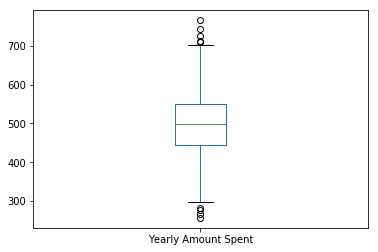

In [61]:
pandas.plot.box()

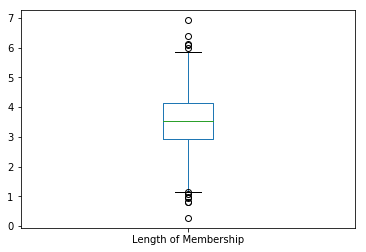

In [62]:
datos.select("Length of Membership").toPandas().plot.box()

In [67]:
modeloDt.transform(nuevosF).show()

+-----+--------------------+-----------------+
|email|            features|       prediction|
+-----+--------------------+-----------------+
|    a|[35.0,10.0,40.0,4.0]|547.1765135962706|
|    b|[100.0,15.0,60.0,...|494.4266881836496|
|    c|[45.0,15.0,25.0,7.0]|721.8511262604533|
+-----+--------------------+-----------------+

